# ROMY Status File

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame, merge
from andbro__save_to_pickle import __save_to_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.load_beat import __load_beat
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals

## Configurations

In [21]:
config = {}


config['tbeg'] = obs.UTCDateTime("2024-01-14")
config['tend'] = obs.UTCDateTime("2024-01-17")
# config['tend'] = obs.UTCDateTime("2023-09-25")

config['ring'] = "U"

config['path_to_figures'] = data_path+f"quality_status/figures/"

config['path_to_data'] = archive_path+f"temp_archive/"


### Load Status Data

In [22]:
from functions.load_status import __load_status

In [23]:
statusU = __load_status(config['tbeg'], config['tend'], "U", config['path_to_data'])

In [24]:
statusU[statusU.quality.eq(0)].size

406

In [25]:
statusU[statusU.quality.eq(1)].size

29813

In [26]:
# statusU[statusU.times_utc > obs.UTCDateTime("2023-09-06 23:59")]

In [27]:
statusV = __load_status(config['tbeg'], config['tend'], "V", config['path_to_data'])

In [28]:
statusZ = __load_status(config['tbeg'], config['tend'], "Z", config['path_to_data'])

### Plotting

In [29]:
statusU = statusU.sort_values(by="times_utc")
statusV = statusV.sort_values(by="times_utc")
statusZ = statusZ.sort_values(by="times_utc")

In [30]:
def __makelplot_single_status(df, ring):

    names = ["quality", "fsagnac", "mlti", "ac_threshold", "dc_threshold"]
    bars = np.ones(len(names))-0.5

    arr = np.ones((len(names), df['quality'].size))

    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])
    cmap.set_bad("w")

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=False, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    # ax.set_xlabel("Time (days)")

    ax.set_title(f"Quality Status of R{ring}")

    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

/tmp/ipykernel_3092383/641221408.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


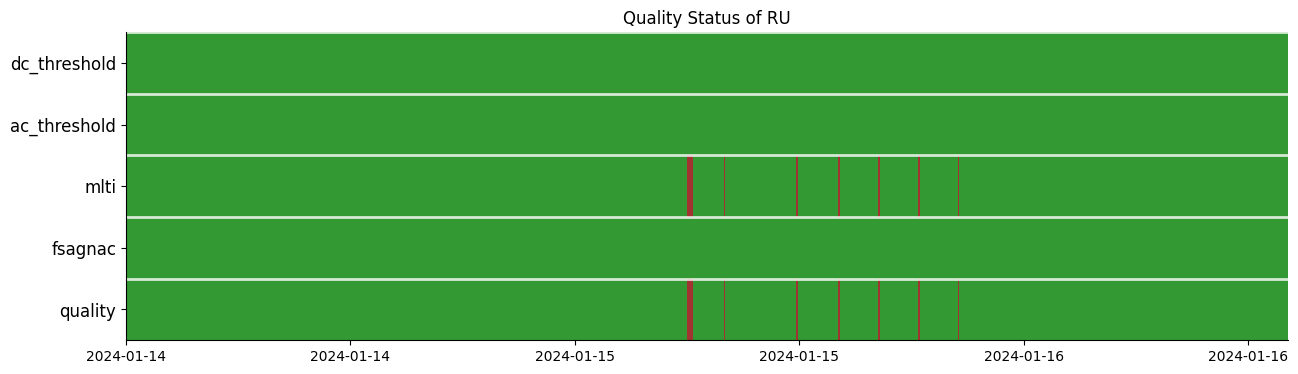

/tmp/ipykernel_3092383/641221408.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


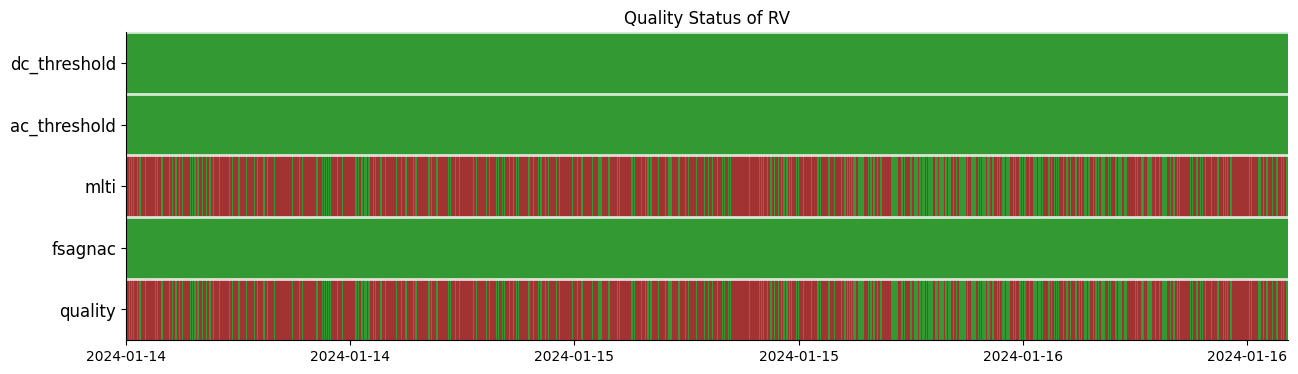

/tmp/ipykernel_3092383/641221408.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


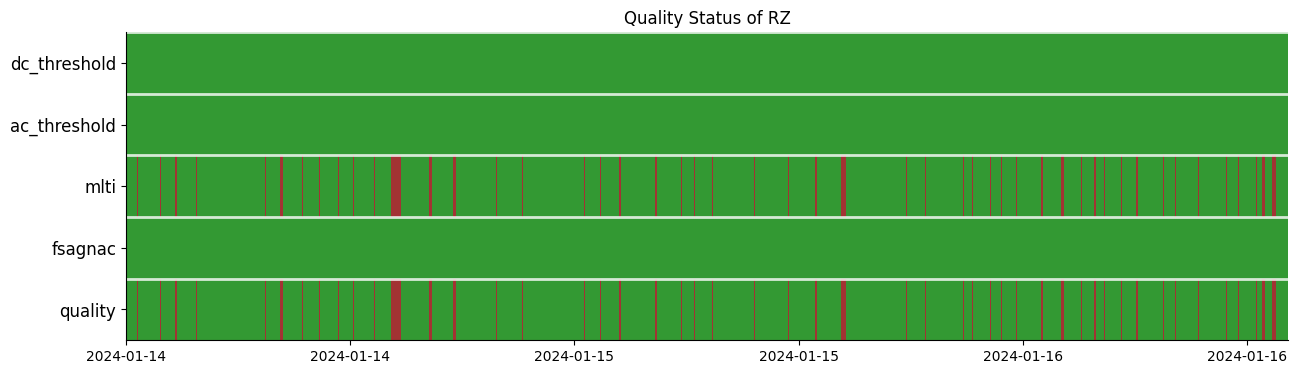

In [31]:
fig = __makelplot_single_status(statusU, "U")

fig = __makelplot_single_status(statusV, "V")

fig = __makelplot_single_status(statusZ, "Z")


# print(f" -> stored: {config['path_to_figures']}R{config['ring']}_{config['tbeg'].date}_status.png")
# fig.savefig(config['path_to_figures']+f"R{config['ring']}_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')

In [32]:
## create sub-frames
statusZ_mod = statusZ[['times_utc','quality']]
statusU_mod = statusU[['times_utc','quality']]
statusV_mod = statusV[['times_utc','quality']]

## remove NaN from times
statusZ_mod = statusZ_mod.dropna(subset="times_utc").reset_index()
statusV_mod = statusV_mod.dropna(subset="times_utc").reset_index()
statusU_mod = statusU_mod.dropna(subset="times_utc").reset_index()

# statusZ_mod.shape, statusU_mod.shape, statusV_mod.shape

## make times all to string objects
statusZ_mod['times_utc'] = statusZ_mod.times_utc.astype(str)
statusU_mod['times_utc'] = statusU_mod.times_utc.astype(str)
statusV_mod['times_utc'] = statusV_mod.times_utc.astype(str)

In [33]:
## create new frame with all rings and their quality
df_new = statusZ_mod.copy()

print(df_new)


df_new = df_new.merge(statusU_mod, how="outer", on=["times_utc"])

print(df_new)

df_new = df_new.merge(statusV_mod, how="outer", on=["times_utc"])

print(df_new)

## drop irrelevant columns
df_new.drop(columns=["index_x", "index_y", "index"], inplace=True)

## renaming ...
df_new.rename(columns={"quality_x":"RZ", "quality_y":"RU", "quality":"RV"}, inplace=True)

## add relative times
ref_time = df_new.times_utc.iloc[0]
df_new['times_utc_sec'] = np.array([abs(obs.UTCDateTime(ref_time) - obs.UTCDateTime(_t) +30) for _t in df_new.times_utc])

## add RW column
df_new['RW'] = np.ones(df_new.shape[0])*np.nan

## sort all by time
df_new.sort_values(by="times_utc", inplace=True)

      index                    times_utc  quality
0         3  2024-01-14T00:00:30.000000Z      1.0
1         4  2024-01-14T00:01:30.000000Z      1.0
2         5  2024-01-14T00:02:30.000000Z      1.0
3         6  2024-01-14T00:03:30.000000Z      1.0
4         7  2024-01-14T00:04:30.000000Z      1.0
...     ...                          ...      ...
4315   1438  2024-01-16T23:55:30.000000Z      1.0
4316   1439  2024-01-16T23:56:30.000000Z      1.0
4317      0  2024-01-16T23:57:30.000000Z      1.0
4318      1  2024-01-16T23:58:30.000000Z      1.0
4319      2  2024-01-16T23:59:30.000000Z      1.0

[4320 rows x 3 columns]
      index_x                    times_utc  quality_x  index_y  quality_y
0           3  2024-01-14T00:00:30.000000Z        1.0      3.0        1.0
1           4  2024-01-14T00:01:30.000000Z        1.0      4.0        1.0
2           5  2024-01-14T00:02:30.000000Z        1.0      5.0        1.0
3           6  2024-01-14T00:03:30.000000Z        1.0      6.0        1.0
4    

/tmp/ipykernel_3092383/2099239175.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


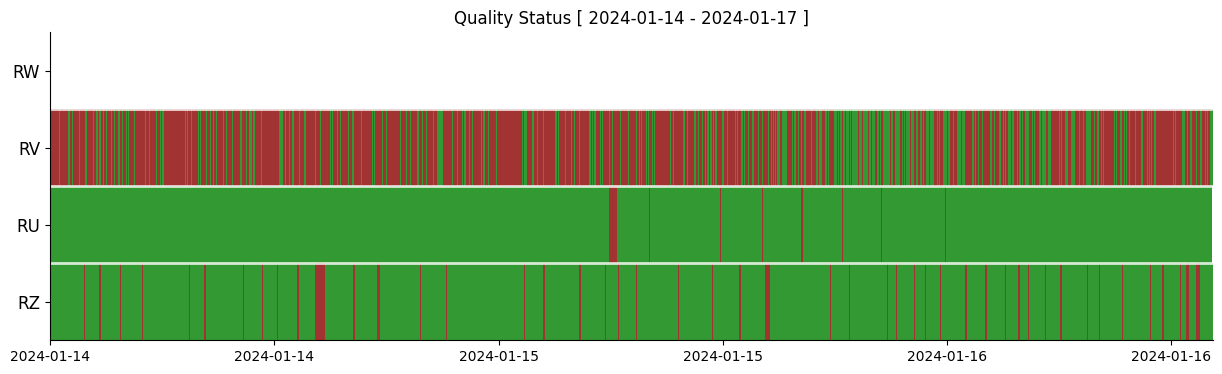

In [34]:
def __makelplot_all_status(df):

    names = ["RZ", "RU", "RV", "RW"]

    ## make statistics
    df_stats = DataFrame(columns=["ring", "R_0", "R_1", "R_nan", "R_N", "R_0_p", "R_1_p", "R_nan_p"])

    R_0, R_1, R_nan = np.zeros(len(names)), np.zeros(len(names)), np.zeros(len(names))
    for _n, k in enumerate(names):

        R_0 = df_new[k][df_new[k] == 0].size
        R_1 = df_new[k][df_new[k] == 1].size
        R_nan = df_new[k][df_new[k].isnull()].size
        R_N = df_new[k].size

        R_0_p = round(R_0/R_N*100, 2)
        R_1_p = round(R_1/R_N*100, 2 )
        R_nan_p = round(R_nan/R_N*100, 2)

        df_stats.loc[len(df_stats)] = [k, R_0, R_1, R_nan, R_N, R_0_p, R_1_p, R_nan_p]


    bars = np.ones(4)-0.5

    arr = np.ones((4, df.shape[0]))

    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])
    cmap.set_bad("w")

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    ax.set_xlim(left=0)

    ax.set_title(f"Quality Status [ {config['tbeg'].date} - {config['tend'].date} ]")

    ## add dates for x-axis
    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)
    ax.tick_params(axis='x', labelsize=font-2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

fig = __makelplot_all_status(df_new);

fig.savefig(config['path_to_figures']+f"overview_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [35]:
df_stats = DataFrame(columns=["ring", "R_0", "R_1", "R_nan", "R_N", "R_0_p", "R_1_p", "R_nan_p"])

rings = ['RZ', 'RU', 'RV', 'RW']

R_0, R_1, R_nan = np.zeros(len(rings)), np.zeros(len(rings)), np.zeros(len(rings))
for _n, k in enumerate(rings):

    R_0 = df_new[k][df_new[k] == 0].size
    R_1 = df_new[k][df_new[k] == 1].size
    R_nan = df_new[k][df_new[k].isnull()].size
    R_N = df_new[k].size

    R_0_p = round(R_0/R_N*100, 2)
    R_1_p = round(R_1/R_N*100, 2)
    R_nan_p = round(R_nan/R_N*100, 2)

    df_stats.loc[len(df_stats)] = [k, R_0, R_1, R_nan, R_N, R_0_p, R_1_p, R_nan_p]

df_stats

,ring,R_0,R_1,R_nan,R_N,R_0_p,R_1_p,R_nan_p
0,RZ,302,4018,0,4320,6.99,93.01,0.00
1,RU,58,4259,3,4320,1.34,98.59,0.07
2,RV,2928,1392,0,4320,67.78,32.22,0.00
3,RW,0,0,4320,4320,0.00,0.00,100.00


/tmp/ipykernel_3092383/2881923947.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in vals])


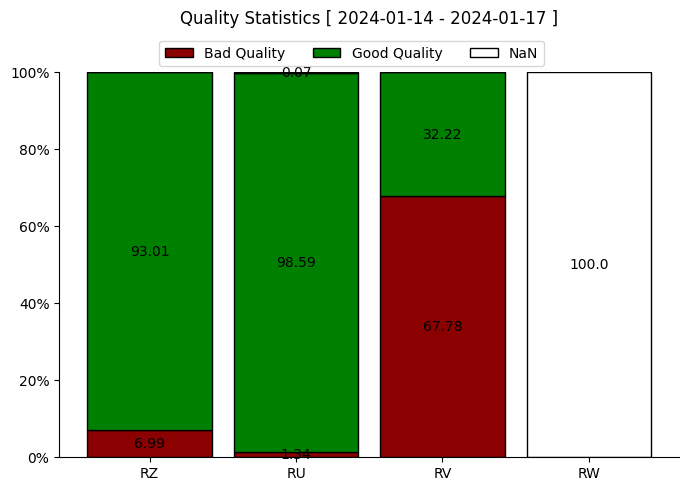

In [36]:
def __makeplot_statistics():

    barWidth = 0.85
    r = range(df_stats.ring.size)

    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    ax.bar(r, df_stats.R_0_p,
            color='darkred', edgecolor='k', width=barWidth, label="Bad Quality")

    ax.bar(r, df_stats.R_1_p, bottom=df_stats.R_0_p,
            color='green', edgecolor='k', width=barWidth, label="Good Quality")

    ax.bar(r, df_stats.R_nan_p, bottom=[i+j for i,j in zip(df_stats.R_0_p, df_stats.R_1_p)],
            color='white', edgecolor='k', width=barWidth, label="NaN")

    ax.set_xticks(r, df_stats.ring)

    ax.legend(loc='upper left', bbox_to_anchor=(0.15, 1.1), ncol=3)

    ax.set_title(f"Quality Statistics [ {config['tbeg'].date} - {config['tend'].date} ]", pad=35)

    vals = ax.get_yticks()
    ax.set_yticklabels([f'{int(x)}%' for x in vals])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for c in ax.containers:

        # Optional: if the segment is small or 0, customize the labels
        labels = [round(v.get_height(), 2) if v.get_height() > 0 else '' for v in c]

        # remove the labels parameter if it's not needed for customized labels
        plt.bar_label(c, labels=labels, label_type='center')

    plt.show();
    return fig

fig = __makeplot_statistics()

fig.savefig(config['path_to_figures']+f"overview_percent_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')
